Notebook for TPD submisison

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib widget
import time
import numpy as np
from aeromaps.core.process import create_process
from aeromaps.core.models import models_complex
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    Fleet,
    AircraftParameters,
    Aircraft,
)


# custom_params = {"axes.spines.right": False, "axes.spines.top": False}

# # Update Matplotlib rcParams
# plt.rcParams.update(custom_params)

# 0- Introduction

Code to draw a simple MACC 

In [2]:
# Generate random data for simple MACC
np.random.seed(0)
data = {
    "names": ["A", "B", "C", "D", "E"],
    "abatement_effective": [5, 1, 2, 3, 4],
    "carbon_abatement_cost": [-20, 20, 100, 28, 50],
}

df = pd.DataFrame(data).set_index("names")

maccpos_df = df.sort_values(by="carbon_abatement_cost")

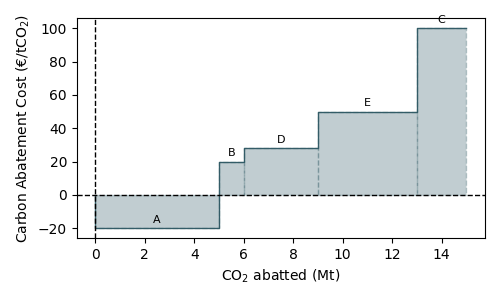

In [3]:
fig, ax = plt.subplots(figsize=(5, 3))

##### POS ######

heights_pos = maccpos_df["carbon_abatement_cost"].to_list()
names_pos = maccpos_df.index.to_list()
heights_pos.insert(0, 0)
heights_pos.append(heights_pos[-1])

# # MAx effective maccpos
widths_effective_pos = maccpos_df["abatement_effective"].to_list()
widths_effective_pos.insert(0, 0)
widths_effective_pos.append(widths_effective_pos[-1])


maccpos_curve = ax.step(
    np.cumsum(widths_effective_pos) - widths_effective_pos,
    heights_pos,
    where="post",
    color="#335C67",
    label="Marginal abatement cost",
    linewidth=1,
)

for i in range(len(widths_effective_pos) - 2):
    x_position = (np.cumsum(widths_effective_pos)[i] + np.cumsum(widths_effective_pos)[i + 1]) / 2
    y_position = min(2000 - 10, heights_pos[i + 1] + 5)
    ax.text(
        x_position,
        y_position,
        f"{names_pos[i]}",
        rotation=0,
        size=8,
        ha="center",
        va="center",
    )


for i in range(0, (len(widths_effective_pos) - 2)):
    # Create a polygon for each step
    polygon = plt.Polygon(
        [
            (np.cumsum(widths_effective_pos)[i], 0),
            (np.cumsum(widths_effective_pos)[i], heights_pos[i + 1]),
            (np.cumsum(widths_effective_pos)[i + 1], heights_pos[i + 1]),
            (np.cumsum(widths_effective_pos)[i + 1], 0),
        ],
        closed=True,
        alpha=0.3,
        facecolor="#335C67",
        edgecolor="#335C67",
        linewidth=1,
        linestyle="--",
    )
    ax.add_patch(polygon)


ax.set_ylabel("Carbon Abatement Cost (€/t$\mathregular{CO_2}$)")
ax.set_xlabel("$\mathregular{CO_2}$ abatted (Mt)")

ax.axhline(0, color="black", linestyle="--", linewidth=1)

ax.axvline(0, color="black", linestyle="--", linewidth=1)

fig.tight_layout()
fig.savefig("TPD images/simple_cac.pdf")

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [4]:
process = create_process(
    models=models_complex,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)

## 1-a) Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [5]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [3.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [3.0]

## 1-b) Aircraft fleet

**Hypotheses considered for aircraft DOC and new aircraft introduction:**
The previously defined air traffic is flown by the default AeroMAPS fleet, and new aircraft. 

- A default fleet: an "old" and a "recent" aircraft for three markets: Short (<1500 km), Medium (1500-4000 km) and Long Range (>4000 km). 
- New aircraft are introduced
    - <u>Short Range:</u>
        - Hydrogen aircraft in 2035
    - <u>Medium Range:</u>
        - Drop-in aircraft in 2030
        - Hydrogen aircraft in 2045  
    - <u>Long Range:</u>
        - Drop-in aircraft in 2030
        - Drop-in aircraft in 2045
        
    - Efficiency assumptions: drop in aircraft introduced in 2030 use 20% less energy than the current ("recent"), the second long-range dropin aircraft introduced in 2045 uses 30% less energy than the "recent. Hydrogen aircraft uses the same ammount of energy than the recent aircraft.
    - Aircraft RC and NRC cost assumption are based on [this article](https://www.eucass.eu/doi/EUCASS2023-593.pdf), but these parameter are not used in this article. There is currently <u>no automated link between RC+NRC and DOC on AeroMAPS </u>. Consistent values are filed nevertheless. Same for ASK per year per A/C.
    
    
    - Aircraft DOC are obtained using the same article and regrouped in two categories
        - DOC-ENERGY is computed using the energy consumption of the aircraft and the MFSP of the corresponding energy (see below). 
        - DOC-NON-ENERGY encompass all other direct operating Costs (Navigation, FA/Pilots, MRO,...). AeroMAPS requires the evolution of this parameter compared to the reference. For  information, the capital part represent around 16% of the total DOC-NE and other costs 84%. A composite evolution can therefore be computed. The capital part is obtained (outside of AeroMAPS) by computing an equivalent annual cost (**EAC**), using an annuity factor of 0.07 (computed for 25 years, under a 5% Interest rate). It can be modified to represent a increase in aircraft cost or lifespan. ($\text{EAC} = \frac{CAP_{t0} \times i}{1 - (1 + i)^{-n}} $). For the time being, the DOC-NE of drop-,n aircraft is left unchanged, and the DOC NE of both hydrogen aircraft is  set at 106% and 110% of the basis according to [Hoelzen et al.](https://www.sciencedirect.com/science/article/pii/S0360319921043184#fig2)
        
    
    

    
        
- Aircraft fleet renewal rates are set to 25 years. It corresponds to both the aircraft life and the duration necessary to renew the whole fleet with current fleet renewal models of AeroMAPS.






In [6]:
# Aircraft fleet

## Initialization
fleet = process.fleet

## Short Range aircraft
short_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=0.0,
    nox_evolution=-75.0,
    soot_evolution=-100.0,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    ask_year=280000000,
    rc_cost=50000000,
    nrc_cost=10000000000.0,
)
short_range_aircraft = Aircraft(
    "New SR-H2", parameters=short_range_aircraft_params, energy_type="HYDROGEN"
)
fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

## Medium Range
medium_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2030,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    ask_year=352000000.0,
    rc_cost=60000000.0,
    nrc_cost=10000000000.0,
)
medium_range_aircraft = Aircraft(
    "New MR-DI", parameters=medium_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

## Medium Range
medium_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2045,
    consumption_evolution=0.0,
    nox_evolution=-75.0,
    soot_evolution=-100,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    ask_year=352000000.0,
    rc_cost=6600000.0,
    nrc_cost=15000000000.0,
)
medium_range_aircraft = Aircraft(
    "New MR-H2", parameters=medium_range_aircraft_params, energy_type="HYDROGEN"
)
fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

## Long Range
long_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2030,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    ask_year=912000000.0,
    rc_cost=150000000.0,
    nrc_cost=25000000000.0,
)
long_range_aircraft = Aircraft(
    "New LR-DI", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)


## Long Range
long_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2045,
    consumption_evolution=-30.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    ask_year=912000000.0,
    rc_cost=150000000.0,
    nrc_cost=25000000000.0,
)
long_range_aircraft = Aircraft(
    "New LR-DI2", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)


## Fleet renewal
fleet.categories["Short Range"].parameters.life = 25
fleet.categories["Medium Range"].parameters.life = 25
fleet.categories["Long Range"].parameters.life = 25

It is possible to visualize the resuting compostion of the fleet on the three segments defined.

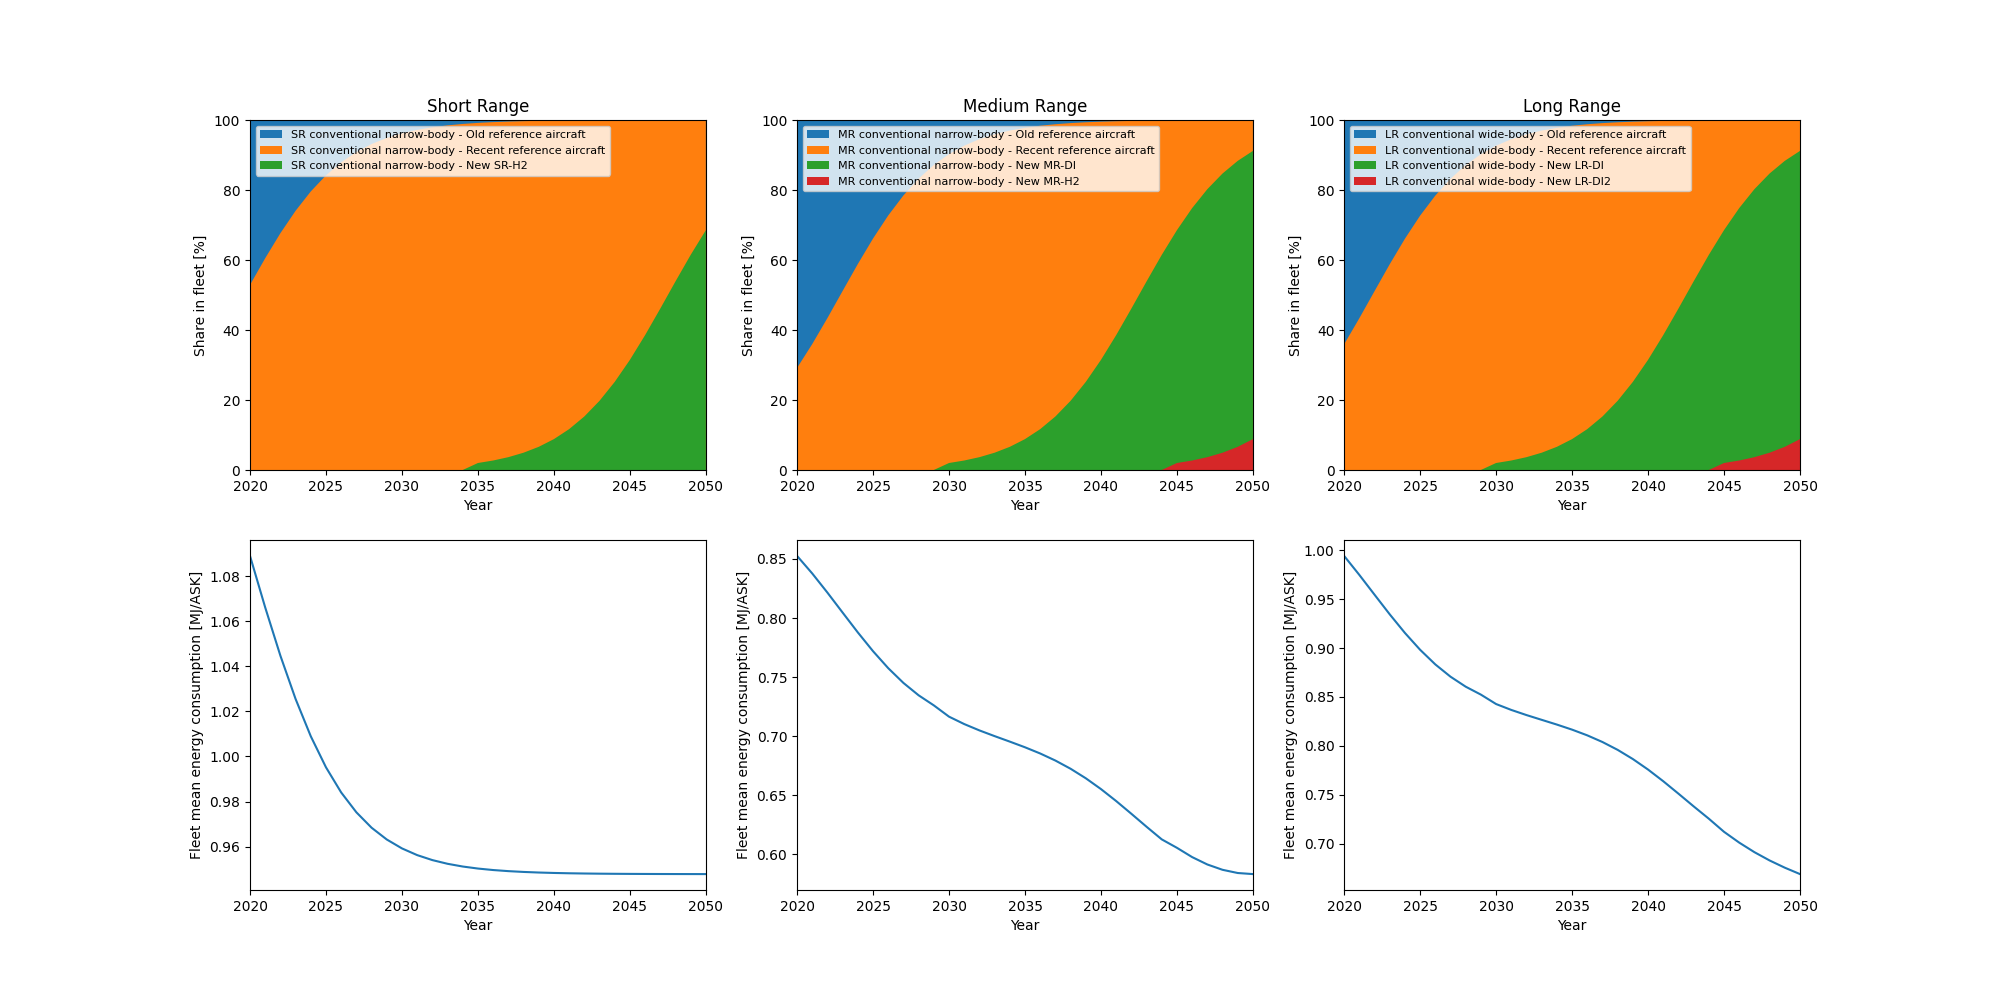

In [7]:
process.fleet_model.compute()
process.fleet_model.plot()

### 1-c) Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [8]:
process.parameters.load_factor_end_year = 89  # 2019 value: 82.399312

In [9]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## 1-d) Energy

***Pathway choices:***
An energy mix is defined, relatively arbitraily, but inspired from [ReFuel-EU](https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=OJ:L_202302405#d1e35-29-1) blending mandates. Sythetic fuels are defined as fuels of non-biological origin, either hydrogen or e-fuels, produced with DAC.

| Year | SAF (%) | incl. Synthetic Fuels (%) |
|---|---|---|
| 2025 | 2 | 0 |
| 2030 | 6 | 1.2 |
| 2035 | 20 | 5 |
| 2040 | 34 | 10 |
| 2045 | 42 | 15 |
| 2050 | 70 | 35 |

It is easy to define blending shares for drop-in fuels. However, hydrogen consumption is more dependant on how many hydrogen aircraft are used.
We therefore consider that the Refuel-EU blending mandates are applied directly to the dropin fuels (more ambitious than refuel-EU).

Within biofuel pathways, shares are defined according to their biomass availability.

Hydrogen production starts from the current [share](https://iea.blob.core.windows.net/assets/c5bc75b1-9e4d-460d-9056-6e8e626a11c4/GlobalHydrogenReview2022.pdf) (p71) follows repartition of [NZE](https://www.iea.org/reports/hydrogen-2156) until 2050. Note that these are industry wide productions, and aviation might larger share of electrolysis hydrogen.

| Year | Coal (%) | Coal + CCS (%) | Gas (%) | Gas+CCS (%) | Electrolysis (%) |
|---|---|---|---|---|---|
| 2022 | 25 | 0.25 | 75 | 0.75 | 0 |
| 2030 | 13.4 | 3 | 40 | 9  | 34.6 |
| 2035 | 7.6 | 3.9 | 22.6 | 11.9 | 54 |
| 2050 | 1 | 5 | 3 | 15 | 76 |


***Emission factors & availabilities:*** All emissions factors/energy availabilities are default AeroMAPS median emission factors (see documentation).


***Cost Parameters:***

- **Biofuels:** All values for biofuels are derived from a litterature review (refer to resources/cost_data/Biomass_Data.xlsx); Values are set to the median value and no evolution (such as learning rates) is assumed. Municipal solid waste feedstock is considered as free by the sources reviewed, although it could be diffrent once there is a demand for it.

| Pathway | Capex (€/(kg/day)) | Opex (€/L) | Feedstock Cost (cts €/MJ biomass) |
|---|---|---|---|
| HEFA-FOG | 491 | 0.17 | 1.27 |
| HEFA-Others | 654 | 0.13 | 1.22 |
| FT-MSW | 3042 | 0.29 | 0 |
| FT-Others | 2043 | 0.27 | 0.7 |
| AtJ | 1547 | 0.21 | 1.02 |

- **Hydrogen - Electrolysis:** (refer to resources/cost_data/Hydrogen_based_process.xlsx). 
    - Values for OPEX base on a litterature review, mostly relying on an institutional report from the [UK department of Energy](https://www.gov.uk/government/publications/hydrogen-production-costs-2021). Time dynamics represented by a transition from pessimistic in 2020 to median in 2030 to optimistic in 2050 and beyond. 
    - Values  and time Dynamic for CAPEX and efficiency using data from an [external litterature review](https://h2.pik-potsdam.de/H2Dash/)
    - Both dedicated renewable and grid electricity are used in this work.

| Year | Capex (€/(kg $H_2$/day)) | Variable Opex (€/kg $H_2$) | Fixed Opex (€/(kg $H_2$/day)/year)  | Efficiency (%) |
|:---:|:---:|:---:|:---:|:---:|
| 2020 | 533 | 0.3 | 25 | 0.64 |
| 2030 | 355 | 0.19 | 21 | 0.66 |
| 2040 | 261 |  |  |  |
| 2050 | 210 | 0.12 | 20 | 0.72 |

- **Hydrogen - Other pathways:** Based on literature review (see supplementary material). Fixed cost references based on [IEA Global Hydrogen Review 2021](https://iea.blob.core.windows.net/assets/2ceb17b8-474f-4154-aab5-4d898f735c17/IEAGHRassumptions_final.pdf). CCS is assumed to cost 22.5€/t$CO_2$

| Pathway | Capex (€/(kg/day)) | Fixed Opex (€/(kg/day)/year)  | Efficiency (%) | 
|:---:|:---:|:---:|:---:|
| Gas reforming | 917 | 43.1 | 76 |
| Gas reforming + CCS | 1728 | 69.1 | 69 | 
| Coal gasification | 2304 | 115.2 | 60 | 
| Coal gasification + CCS | 2399 | 119.95 | 58 |



- **Hydrogen - Liquefaction and transport:**
    Hydrogen production and transportation is considered similarly for all the production pathways. Based on literature review (see supplementary material) presented in [hoelzen et al.](https://www.sciencedirect.com/science/article/pii/S0360319921043184). Prices swicth from pessimistic to median to optimistic values in 2020-2035-2050, as well as efficiencies, which are defined by the ratio of the hydrogen energy with this value plus the energy necessary to liquefy the hydrogen. Opex are taken as 4% of Capex annually. Transport is weakly modelled and assumed to represent 10% of the total hydrogen production cost.
| Year | Capex (€/(kg $H_2$/day)) | Efficiency (%) |
|---|---|---|
| 2020 | 2248 | 0.75 |
| 2030 | 1457 | 0.82 |
| 2050 | 899 | 0.83 |


- **Efuels:** Based on literature review (refer to resources/cost_data/Hydrogen_based_process.xlsx). Time dynamics represented by a transition from pessimistic in 2020 to median in 2035 to optimistic in 2050 and beyond. Both dedicated renewable and grid electricity are used in this work.
    - Values for CO2 DAC taken from a litterature review.  2020 and 2030 value based on the trajcetory taken by [Ueckerdt](https://www.nature.com/articles/s41558-021-01032-7), but 2050 value is capped at 100 USD for consistency with other sources reviewed. 
| Year | Capex (€/(kg $H_2$/day)) | Opex (€/L) | $H_2$-> PtL efficiency (%) | Specific $CO_2$ (kg/L) | CO2 DAC Cost (€/t) |
|---|---|---|---|---|---|
| 2020 | 2496 | 0.34 | 74 | 4.3 | 460 |
| 2030 | 1528 | 0.30 | 74 | 3.58 | 150 |
| 2050 | 510 | 0.20 | 74 | 2.55 | 90 |

**Hypotheses considered for energy inputs:**

- **Electricity:** Electricity is considered via two options. 
    - *Grid*: Grid electricity input is assumed to cost 70€ per MWh in 2019, as a coarse mean between [europe](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_205/default/table?lang=en) and [usa](https://www.statista.com/statistics/190680/us-industrial-consumer-price-estimates-for-retail-electricity-since-1970/). If considering grid electricity alows for high load factors, it requires the full consideration of backups and tranportation systems (infrastructure), meaning that considering per technology LCOE can be a major shortcomming. Grid electricity prices in 2050 are not widely available, but a value of 100€/Mwh seems to be adequate with respect to total system costs estimated by French network administrator [RTE](https://assets.rte-france.com/prod/2022-06/Futurs%20%C3%A9nerg%C3%A9tiques%202050%20_%20rapport%20complet.zip). Baseline emission factor for the grid is [450 g$CO_2$/KWh](https://ourworldindata.org/grapher/carbon-intensity-electricity?time=2019) and are arbitrarily set at 20 g$CO_2$/KWh in 2050, in line with total low-carbon system emissions of [RTE](https://assets.rte-france.com/prod/2022-06/. Intermediate points are set at 160g in 2030 and 40g in 2040.
    
    - *Dedicated renewables*: (refer to resources/cost_data/Hydrogen_based_process.xlsx)
        - Wind:
        
        | Year | LCOE (€/MWh) | EF (gCO2/kWh) | Load Factor (%) | 
        |---|---|---|---|
        | 2020 | 61 | 15 | 40 | 
        | 2030 | 58 | 13.5 | 43 | 
        | 2040 | 52 | 12.5 | N/A | 
        | 2050 | 46 | 11.5 | 45 | 
            
        - PV:
        
        | Year | LCOE (€/MWh) | EF (gCO2/kWh) | Load Factor (%) | 
        |---|---|---|---|
        | 2020 | 58 | 43 | 13 | 
        | 2030 | 37 | 36 | 14 | 
        | 2040 | 33 | 30 | N/A | 
        | 2050 | 26 | 21 | 14 | 


- **Fossil fuels**
    - Fossil based hydrogen (gas/coal) prices from [IEA Global Hydrogen Review 2021](https://iea.blob.core.windows.net/assets/2ceb17b8-474f-4154-aab5-4d898f735c17/IEAGHRassumptions_final.pdf), default values of AeroMAPS.
    
    - **Kerosene**: median of 2015-2019 Weekly U.S. Gulf Coast Kerosene-Type Jet Fuel Spot Price (refer to resources/cost_data/Biomass_data.xlsx); default aeromaps value.

    


In [10]:
# Energy settings: production choices

# Aircraft energy - Introduction of alternative drop-in fuels

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040,2045, 2050]
process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040,2045, 2050]
process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]


## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
process.parameters.hydrogen_electrolysis_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_electrolysis_share_reference_years_values = [0, 34.6, 54, 76]

process.parameters.hydrogen_gas_ccs_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0.75, 9, 11.9, 15]

process.parameters.hydrogen_coal_ccs_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0.25, 3, 3.9, 5]

process.parameters.hydrogen_gas_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_gas_share_reference_years_values = [75, 40, 22.6, 3]

In [11]:
# Energy settings: cost

# BIOFUELS
# ==> Default AeroMAPS values (see table above)

# HYDROGEN

## Electrolysis 
### Efficicency 
process.parameters.electrolysis_efficiency_reference_years = [2020, 2030, 2050]
process.parameters.electrolysis_efficiency_reference_years_values = [0.64, 0.66,0.72]
### CAPEX 
process.parameters.electrolyser_capex_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electrolyser_capex_reference_years_values = [533, 355, 261, 210]
### Fixed OPEX
process.parameters.electrolyser_fixed_opex_reference_years = [2020, 2030, 2050]
process.parameters.electrolyser_fixed_opex_reference_years_values = [25.05, 20.57, 19.62]
### Variable OPEX
process.parameters.electrolyser_variable_opex_reference_years = [2020, 2030, 2050]
process.parameters.electrolyser_variable_opex_reference_years_values = [0.3, 0.19, 0.12]

## Fossil (Gas or Coal with or without CCS)
# ==> Default AeroMAPS values (see table above)

## Liquefaction
### CAPEX 
process.parameters.liquefier_capex_reference_years = [2020, 2030, 2050]
process.parameters.liquefier_capex_reference_years_values = [2248, 1457, 899]
### Efficicency 
process.parameters.liquefaction_efficiency_reference_years = [2020, 2030, 2050]
process.parameters.liquefaction_efficiency_reference_years_values = [0.75, 0.82, 0.83]


# ELECTROFUEL
### Efficicency 
process.parameters.electrofuel_hydrogen_efficiency_reference_years = [2020, 2030, 2050]
process.parameters.electrofuel_hydrogen_efficiency_reference_years_values = [0.74, 0.74,0.74]
### CAPEX 
process.parameters.electrofuel_capex_reference_years = [2020,2030,2050]
process.parameters.electrofuel_capex_reference_years_values = [2496, 1528, 510]

process.parameters.electrofuel_var_opex_reference_years = [2020,2030,2050]
process.parameters.electrofuel_var_opex_reference_years_values = [0.336, 0.296, 0.2]

process.parameters.electrofuel_specific_co2_reference_years = [2020,2030,2050]
process.parameters.electrofuel_specific_co2_reference_years_values = [4.30,3.58,2.552]

process.parameters.co2_cost_reference_years = [2020,2030,2050]
process.parameters.co2_cost_reference_years_values = [0.460, 0.150, 0.09]



# ENERGY INPUT PRICES
## Grid Electricity
# => LF=1

process.parameters.electricity_emission_factor_reference_years = [2020,2030,2040,2050]
process.parameters.electricity_emission_factor_reference_years_values = [429,160,40,20]

process.parameters.electricity_cost_reference_years = [2020,2050]
process.parameters.electricity_cost_reference_years_values = [0.08,0.1]

# # ## PV
# process.parameters.electricity_emission_factor_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_emission_factor_reference_years_values = [43,36,30,21]

# process.parameters.electricity_cost_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_cost_reference_years_values = [0.058, 0.037, 0.033, 0.026]

# process.parameters.electricity_load_factor_reference_years = [2020,2030,2050]
# process.parameters.electricity_load_factor_reference_years_values = [0.13,0.14,0.14]

# ## Wind
# process.parameters.electricity_emission_factor_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_emission_factor_reference_years_values = [15,13.5,12.5,11.5]

# process.parameters.electricity_cost_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_cost_reference_years_values = [0.061, 0.058, 0.052, 0.046]

# process.parameters.electricity_load_factor_reference_years = [2020,2030,2050]
# process.parameters.electricity_load_factor_reference_years_values = [0.4,0.43,0.45]


# Kerosene, Coal, Gas => Default values (see table)

## 1-e) Other parameters 

In [12]:
# Cost parameters

## Carbon tax => Set at zero for MACC curves
process.parameters.carbon_tax_reference_years = [2020, 2030, 2040, 2050]
process.parameters.carbon_tax_reference_years_values = [
    0,
    0,
    0,
    0,
]

In [13]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [14]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 5.0
process.parameters.aviation_electricity_allocated_share = 5.0

# 2- Compute

Run AeroMAPS process

In [15]:
process.compute()

# 3- Analyses

## 3-a) Scenario sustainability 

Lets begin by exploring the sustainability of the scenario:
- $CO_2$ emissions trajectory
- Fuels emission factors
- Ressources consumption

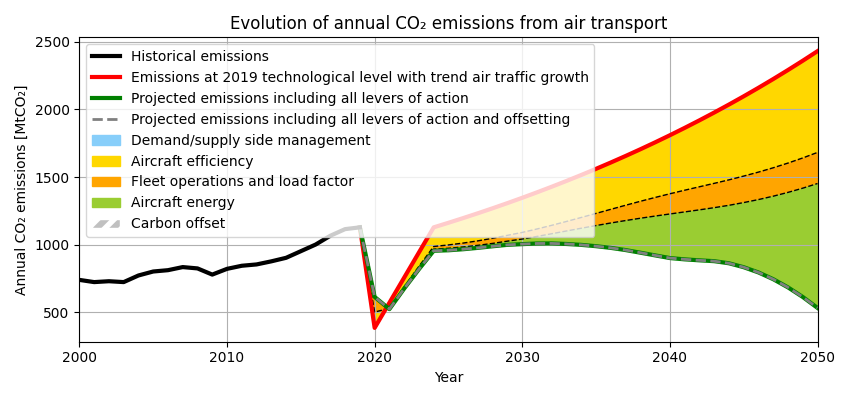

In [16]:
process.plot("air_transport_co2_emissions")

The first graph represents the annual CO2 emission of the air transport as well as the relative contribution of the mitigation levers used.
There are no 'demand management' lever here as the default growth rate of 3% p.a. was kept. As a reminer, this is .6/.8 % below Airbus and Boeing forecast. The effect of cost increase on demand is not modeled.   
Aircraft efficiency plays a large role in the decarbonisation, but it is reminded taht this lever is considered first: considereing operations efficiency first would reduce the gap in their relative contribution.  
Fossil kerosene substitution is efficeint in this scenario: the emissions factors associated with the varios pathways are lower than the kerosene emission factor when they are used, as decribed by the following plot.

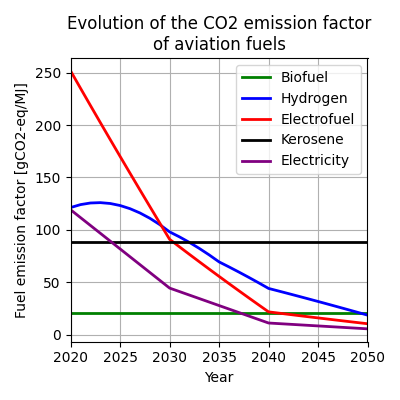

In [17]:
process.plot("emission_factor_per_fuel")

Indeed, considering grid electricity makes electrofuels not climate efficient compared to fossil kerosene before 2030 with teh settings considered. The drop-in fuels blending mandate specified uses only 1.2% electrofuel in 2030, meaning it has a marginal impact on drop-in mean emission factor. This small inneficiency in the period 2025-2030 could be necessary for a faster ramp-up of the production.  
Similarily, hydrogen is efficient only after 2032, because its production is dominated by unabated fossil pathways. But no hydrogen aircraft is introduced until 2035.

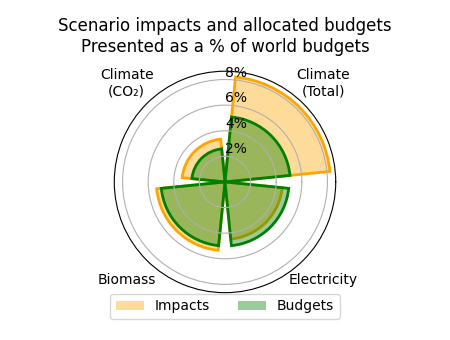

In [18]:
process.plot("multidisciplinary_assessment")

This plots embodies a sectoral budget concept of AeroMAPS: $CO_2$ budgets are defined by Bodies such as IPCC to repsect a given temparature target. In this scenario, it was defined at 850GT (+1.8°C GW at 63% chance) TO CHECK. Similarily, a global budget can be defined in terms of equivalen carbon budgets (accounting for non-CO2 effects), of biomass available for bioenergy, and Electricity (altough the notion of ressource is less direct in this case).  
Then the budgets are scaled down at the sectoral level using allocation rules. In this case, $CO_2$ budget is allocated using a grandfathering approach, giving to aviation a similar share to its annual contribution to annual emissions (2.6%). A similar approach is used for total warming budget. Biomass and electricity budgets are arbitraily set at 5%.  
The secenario respects the energy budgets, but slightly exceeds $CO_2$ budget  vs (3.4 vs 2.6%) andlargely exceeds total warming budget. Non-CO2 mitigation measures are not activated neither investigated in this work as it is not the main topic. They are however crucial to mitigate aviation related warming. Some CO2 mitigation measures have also an impact on non-CO2 (positive or negative).

The budget in itself is not a definitive metric: aviation could be allocated a larger budget than its historic contribution, but it means other sectors should decarbonize faster to respect a gloabl temperature target. 

## 3-b) Costs

Then two cost parameters are presented here:
- Energy Cost 
- Aircraft DOC

interactive(children=(IntSlider(value=2035, description='Year:', max=2050, min=2019), Output()), _dom_classes=…

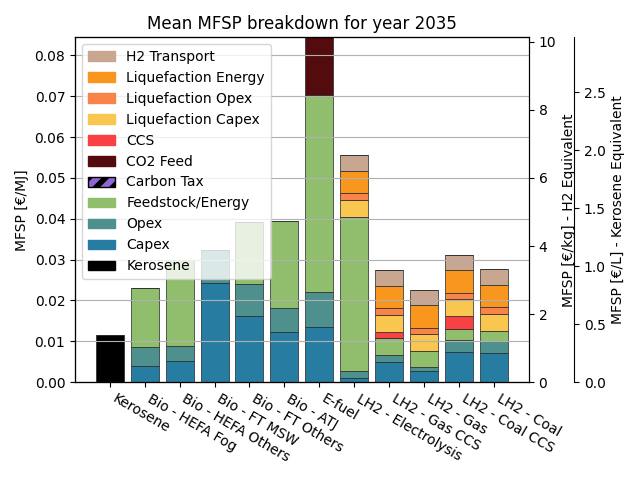

In [19]:
process.plot("mfsp_detailled_year")

This dynamic plot evaluates the minimal fuel selling price (selling price that ensure a null NPV of production plant) of all the pathways considered in AeroMAPS. A common unit €/MJ is sued to compare drop-in and non-drop in fuels on a same graph (*caution: eventual energy efficiency modification of non-dropin fuels is not taken into account here*).  
Kerosene is taken a reference at 0.41 €/L.

 * The cost of each biofuel pathways is fixed during the scenario and between 2 and 4 times the price of fossil fuel. 

 * Hydrogen and e-fuel prices evolves with time. 
    E-fuel is 7 times more expensive than kerosene in 2040 and 6.3 more expensive in 2050. Two remaks: the MFSP is a mean MFSP, inherent to a secnario: a plant with 2040 technology is still 
    delevering fuel in 2050 meaning the MFSP of 2050 is higher than best-technology MFSP in 2050.

 * Price of E-fuel is highly dominated by expenses in electricity procurement. Grid electricity, around 100€/Mwh is considered here. Some of the litterature uses dedicated renewables, cheaper but with a lower load factor. This is discussed later. As seen below, electrofuel MFSp evolution benefits from a decreasing CAPEX/OPEX hypothesis, despite the increase (80->100€/MWh) for electricity prices.   

 * The same remarks apply for hydrogen produced via water electrolysis, for wich lower capex doesn't balance electricity price increase. Fossil based hydrogen is priced around 2 to 3 time the kerosene cost, and carbon capture increses the MFSP by 21% (SMR) and 13% (CG). 



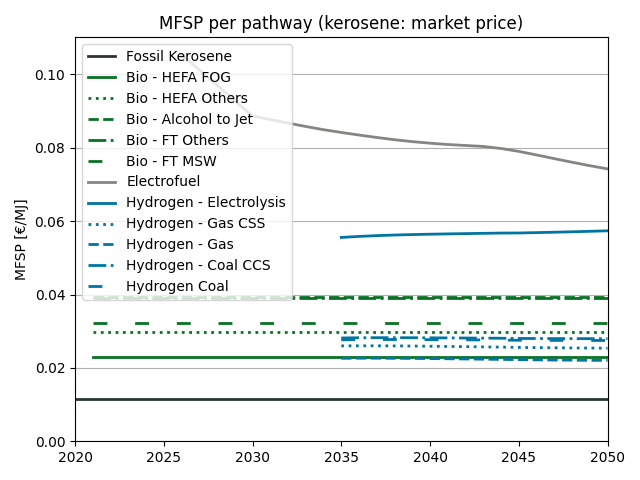

In [20]:
process.plot("energy_mfsp")

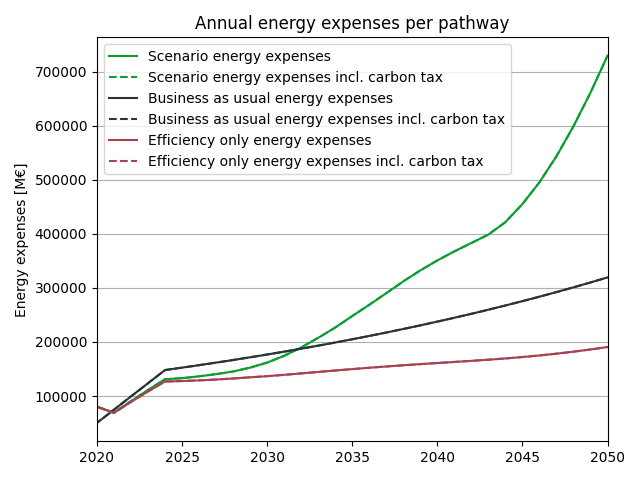

In [21]:
process.plot("energy_expenses_carbon_tax_effect")

The impact of increased energy prices combined to the higher energy prices results in an incread total energy expenses chronology, as illustrated above.

The energy efficiecy alows for significant saving compared to a frozen 2019 technology scenario. However, using alternative fuels cancels these saving by 2032 due o teh significant ramp up to alternative fuels in the specified blending mandate. Two segments can be observed. 
Between 2030 and 2042, and between 2042 and 2050. This correspond to the significant ramp up of moderately expensive biofuels first, and to the one of the e-fuels for the second segement.


This increase in energy expenses (they double, per ASK) might seem important. Although fuel is the [largest expense item](https://www.iata.org/en/iata-repository/publications/economic-reports/covid-19-cash-burn-analysis/) of airlines, both efficiency improvements and dillution by other costs (assumed to remain constant), limits the DOC inrease by 40% and the airfare increase by 25%. (see the plot below).

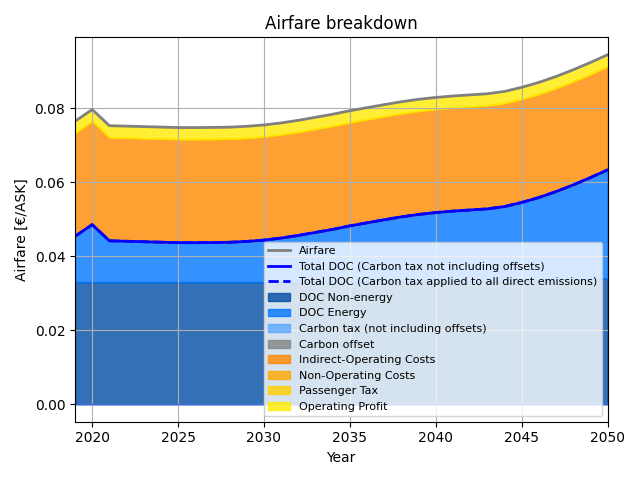

In [22]:
process.plot("airfare_breakdown")

## 3-c) Marginal Abatement Cost Curves

This part of the notebbok is dedicated to the central part of the article. Indeed, MACC curves, for which the methodology was presented in the paper are obtained here and commented.

### 3-c.1/ Instantaneous carbon abatement cost (*ICAC*)

Please refer to the article for the in depth definition of the instantaneous carbon abatement cost.  
To summarize, it is an easy to compute carbon abatement cost to compare, at a given point in time, the relative efficiency of different abatement options. However, it should not be used to decide when a project should be launched compared to a reference carbon value or to chose a project over another. 

interactive(children=(IntSlider(value=2035, description='Year:', max=2050, min=2019), Dropdown(description='Me…

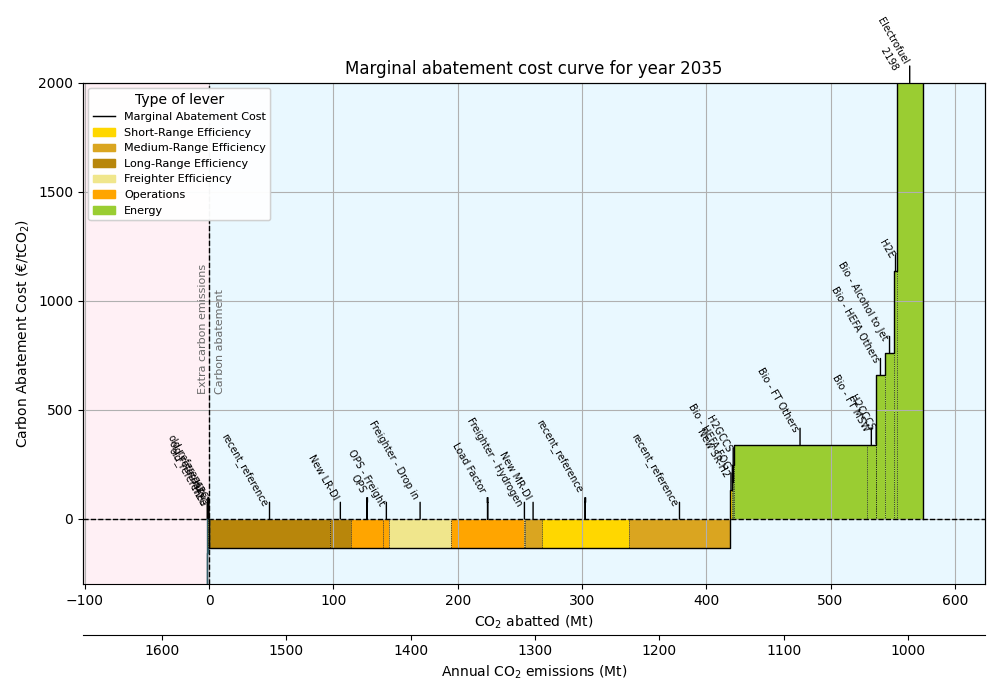

In [23]:
process.plot("annual_MACC")

This first MACC curve can be seen a different points in time using the interactive widget.
A first remark is that two zone can be identified:
- the blue zone 

interactive(children=(Dropdown(description='Metric:', index=1, options=(('Instantaneous Carbon Abatement Cost'…

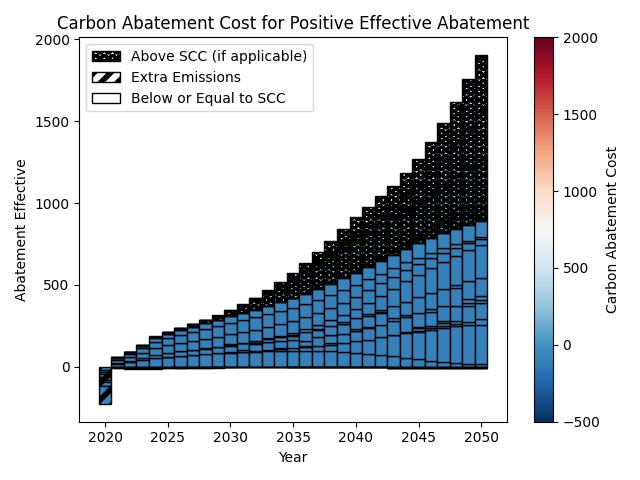

In [24]:
process.plot("scenario_MACC")

In [25]:
process.vector_outputs_df["co2_emissions_2019technology"]

2000            NaN
2001            NaN
2002            NaN
2003            NaN
2004            NaN
2005            NaN
2006            NaN
2007            NaN
2008            NaN
2009            NaN
2010            NaN
2011            NaN
2012            NaN
2013            NaN
2014            NaN
2015            NaN
2016            NaN
2017            NaN
2018            NaN
2019    1127.476770
2020     383.342102
2021     569.375769
2022     755.409436
2023     941.443103
2024    1127.476770
2025    1161.301073
2026    1196.140105
2027    1232.024308
2028    1268.985037
2029    1307.054589
2030    1346.266226
2031    1386.654213
2032    1428.253839
2033    1471.101455
2034    1515.234498
2035    1560.691533
2036    1607.512279
2037    1655.737648
2038    1705.409777
2039    1756.572070
2040    1809.269232
2041    1863.547309
2042    1919.453729
2043    1977.037340
2044    2036.348461
2045    2097.438915
2046    2160.362082
2047    2225.172944
2048    2291.928133
2049    2360.685977
